In [41]:
import pandas as pd
import hvplot.pandas
import dask
import hvplot.dask
import dask.dataframe as dd
import json
import tqdm
from scipy.spatial.distance import cdist
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin as pg
import panel as pn
pn.extension(comms="vscode")


In [2]:
!ls data_dpg_testdata/reduced/ 

mapping_article_files.json
mapping_city.json
mapping_geo.json
mapping_refferer.json
mapping_view_files.json
reduced_articles.csv
reduced_articles_df_article.csv
reduced_articles_df_external_categories.csv
reduced_articles_df_external_entities.csv
reduced_articles_df_external_topics.csv
reduced_articles_df_fixed_set_sensitive.csv
reduced_articles_df_fixed_set_topics.csv
reduced_articles_df_fixed_set_userneeds.csv
reduced_articles_df_internal_topics.csv
reduced_interactions-part-00000-d667af8c-fe5d-4c75-b144-400a5560425d-c000.json.csv
reduced_interactions.csv
reduced_views-part-00000-d667af8c-fe5d-4c75-b144-400a5560425d-c000.json.csv
reduced_views.csv


In [3]:
DATA_FOLDER = "preflight"

In [4]:
ddf_views = dd.read_csv(f'data_dpg_testdata/{DATA_FOLDER}/reduced_views.csv', dtype={'GEO_ZIPCODE': object,
       'REFR_MEDIUM': object, 'IS_LOGGED_IN': object, 'file_name': object,
"privacy_advertising":int,       
"privacy_analytics":int,       
"privacy_functional":int,       
"privacy_geo_location":int,       
"privacy_marketing":int,       
"privacy_non-personalised_ads":int,       
"privacy_personalisation":int,       
"privacy_social_media":int,       
"privacy_target_advertising":int,       
       
       })
ddf_views["DERIVED_TSTAMP"] = dd.to_datetime(ddf_views["DERIVED_TSTAMP"])
ddf_views["hour"] = ddf_views["DERIVED_TSTAMP"].dt.hour
ddf_views["weekday"] = ddf_views["DERIVED_TSTAMP"].dt.weekday
ddf_views["dayofmonth"] = ddf_views["DERIVED_TSTAMP"].dt.day
ddf_views["month"] = ddf_views["DERIVED_TSTAMP"].dt.month
ddf_views = ddf_views.replace("nu.web.advertorial", "nu.web")
device_counts = ddf_views["APP_ID"].value_counts().compute()
sample_amount = device_counts.min()
unique_devices = device_counts.index.unique()
columns_privacy = ddf_views.columns[ddf_views.columns.str.startswith("privacy_")].values
columns_time = ["hour", "weekday", "dayofmonth", "month"]
ddf_views = ddf_views.groupby('APP_ID').apply(lambda df: df.sample(20000), meta=ddf_views.partitions[0]).reset_index(drop=True)
ddf_views.tail()

,APP_ID,ARTICLE_ID,DERIVED_TSTAMP,GEO_CITY,GEO_COUNTRY,GEO_ZIPCODE,REFR_MEDIUM,REFR_URLHOST,QUASI_USER_ID,IS_LOGGED_IN,...,privacy_analytics,privacy_target_advertising,privacy_personalisation,privacy_non-personalised_ads,privacy_marketing,privacy_social_media,privacy_geo_location,privacy_advertising,file_name,hour
19995,nu.android,6204896,2022-06-06 05:38:27.980000+00:00,15,NL,3034,NaN,5,b317d759450df61085d990bdc1c4eaae,0,...,1,0,1,0,1,1,0,1,66,5
19996,nu.android,293328,2022-05-31 15:43:23.194000+00:00,169,NL,6721,NaN,5,ac14224b2094de61372b0a8f81de26bb,0,...,1,0,1,0,1,1,0,1,60,15
19997,nu.android,6211781,2022-07-12 17:22:56.275000+00:00,114,NL,5914,NaN,5,38cbb2dc25026d2ddee501319b3c92b6,0,...,1,0,1,0,1,1,0,1,102,17
19998,nu.android,6202669,2022-05-24 14:55:08.156000+00:00,670,NL,9675,NaN,5,26d6dfd0b34d15f5a16135cea267aa24,0,...,1,0,1,0,1,1,0,1,53,14
19999,nu.android,6197601,2022-04-27 20:49:35.396000+00:00,221,NL,7556,NaN,5,ab461b0315ed804b5c9b7efb3add572b,0,...,1,0,1,0,1,1,0,1,26,20


In [5]:
ddf_views["APP_ID"].value_counts().compute()

nu.android    20000
nu.ios        20000
nu.web        20000
Name: APP_ID, dtype: int64

In [6]:
DATA_FOLDER_ARTICLES = "reduced"
ddf2 = dd.read_csv(f'data_dpg_testdata/{DATA_FOLDER_ARTICLES}/reduced_articles_df_article.csv', dtype={'sub_section': 'object',
       'url': 'object'})
ddf2.head()

,article_id,cds_content_id,brands,title,text,authors,url,main_section,sub_section,num_words,num_sentences,num_chars,first_publication_timestamp,categories_generated,keywords_curated,brand_safety_is_brandsafe,brand_safety_confidence,file_name
0,6178608,article-mm-61e525b134c4a700014017f7,nu.nl,Unilever geeft strijd om overname Aquafresh-ma...,Unilever stelt maandag in een verklaring dat d...,NU.nl/ANP,https://nu.nl/economie/6178608/unilever-geeft-...,Economie,NaN,0,0,0,NaN,Economie,Economie|Unilever|GSK,True,0.1,0
1,6178610,article-mm-61e5302d6ae9490001e6d524,nu.nl,"Had de metro één meter verder gereden, dan was...",_Dit artikel is afkomstig uit HLN. Elke dag ve...,HLN/Jeffrey Dujardin en Robby Dierickx,https://nu.nl/uit-andere-media/6178610/had-de-...,Uit andere media,NaN,0,0,0,NaN,Uit andere media,NaN,True,0.1,0
2,6178739,article-mm-61e5b36154be560001ebf681,nu.nl,Stalker van Kylie Jenner krijgt permanent cont...,De man kreeg vorig jaar al een tijdelijk conta...,NU.nl/ANP,https://nu.nl/achterklap/6178739/stalker-van-k...,Achterklap,NaN,0,0,0,NaN,Achterklap,Kylie Jenner|Achterklap,True,0.1,0
3,6178681,article-mm-61e570a560f2eb0001784c84,nu.nl,Karatsev na bijna 5 uur en 107 onnodige fouten...,De krachtmeting op Melbourne Park duurde om pr...,NU.nl,https://nu.nl/sport/6178681/karatsev-na-bijna-...,Sport,NaN,0,0,0,NaN,Sport|Tennis|Sport Overig,Aslan Karatsev|Australian Open|Tennis,True,0.1,0
4,6178734,article-mm-61e5ac5d3637950001c51671,nu.nl,Lees alles over de tweede award op rij voor Le...,NaN,NU.nl,https://nu.nl/sport/6178734/lees-alles-over-de...,Sport,NaN,0,0,0,NaN,Voetbal|Sport,FIFA-gala,True,0.1,0


In [7]:
ddf2.loc[ddf2["num_sentences"] != 0].compute().head()

,article_id,cds_content_id,brands,title,text,authors,url,main_section,sub_section,num_words,num_sentences,num_chars,first_publication_timestamp,categories_generated,keywords_curated,brand_safety_is_brandsafe,brand_safety_confidence,file_name
138,6181257,article-mm-61f7ce39adc7c500015b6220,nu.nl,Documentaire onthult onderzoek naar vader Máxi...,Zorreguieta diende vijf jaar in de regering ti...,NU.nl,https://nu.nl/algemeen/6181257/documentaire-on...,Media en Cultuur,Koningshuis,481,23,3120,NaN,Media|Koningshuis|Media en Cultuur|Algemeen,Koningin Máxima|Koningshuis|Media|Koning Wille...,True,0.1,0
139,6181210,article-mm-61f7a400b9043c0001ab87c0,nu.nl,"Corrie nu officieel een storm, schade en vertr...",Op verschillende plekken in het land zijn wege...,NU.nl/ANP,https://nu.nl/algemeen/6181210/corrie-nu-offic...,Algemeen,Binnenland,391,41,2636,NaN,Algemeen|Binnenland,Weer|Binnenland,True,0.1,0
141,6179036,article-mm-61e845f2b0cdd60001e17c0f,nu.nl,Nederland met recordaantal sporters naar Olymp...,Sportkoepel NOC*NSF gaf snowboardster Michelle...,Daan de Ridder,https://nu.nl/algemeen/6179036/nederland-met-r...,Olympische Spelen,Olympische Spelen,256,17,1722,NaN,Algemeen|Olympische Spelen|Sport|Sport Overig,Olympische Spelen,True,0.1,0
142,6181293,article-mm-61f7f02f0ad3d9000122fadb,nu.nl,"Handel rond Chinees Nieuwjaar trekt iets aan, ...",Met twee groothandels en 24 gespecialiseerde s...,NU.nl,https://nu.nl/economie/6181293/handel-rond-chi...,Economie,Economie,303,23,1827,NaN,Economie,Economie,True,0.1,0
143,6181350,article-mm-61f822823c63720001797716,nu.nl,Ajax komt er niet uit met Tottenham en ziet af...,Volgens [_De Telegraaf_](https://www.telegraaf...,NU.nl,https://nu.nl/sport/6181350/ajax-komt-er-niet-...,Sport,Voetbal,323,20,2138,NaN,Voetbal|Sport,Steven Bergwijn|Ajax|Voetbal,True,0.1,0


In [31]:
ddf3 = ddf2[["article_id", "num_words", "num_sentences", "num_chars"]].merge(ddf_views[["ARTICLE_ID", "APP_ID"]], how='inner', left_on='article_id', right_on='ARTICLE_ID')
ddf4 = ddf3[["APP_ID", "num_words", "num_sentences", "num_chars"]].loc[ddf3["num_chars"] > 0]
ddf4.groupby("APP_ID").agg(["mean", "std", "count"]).compute()

num_words                    num_sentences                    \
                  mean         std  count          mean        std  count   
APP_ID                                                                      
nu.web      356.221756  225.838307  18579     26.135637  15.968032  18579   
nu.ios      362.631331  237.859285  17631     26.442686  16.624470  17631   
nu.android  358.876584  227.905735  16886     25.980931  15.936928  16886   

              num_chars                      
                   mean          std  count  
APP_ID                                       
nu.web      2286.671726  1453.699309  18579  
nu.ios      2321.175089  1525.424792  17631  
nu.android  2291.661613  1451.163506  16886

In [88]:
factor_1 = ddf4.loc[ddf4["APP_ID"] == "nu.android", "num_words"].compute()
factor_2 = ddf4.loc[ddf4["APP_ID"] == "nu.web", "num_words"].compute()
factor_3 = ddf4.loc[ddf4["APP_ID"] == "nu.ios", "num_words"].compute()

In [89]:
fvalue, pvalue = stats.f_oneway(factor_1, factor_2, factor_3)
fvalue, pvalue

(2.3710478591258215, 0.09339269698233899)

# Correlation device and length of article
The data of number of characters, sentences and words is not normally distributed. Therefore a non-parametric alternative to ANOVA has been applied, Kruskall Wallis H. The result is a signficant relation between the number of words and device type, but not for the number of characters or number of sentences.

In [42]:
# https://www.reneshbedre.com/blog/anova.html

# get ANOVA table as R like output
df_melt = dd.melt(ddf4, id_vars=['APP_ID'], value_vars=["num_words", "num_sentences", "num_chars"]).compute()
df_melt.head()

,APP_ID,variable,value
0,nu.web,num_words,377
1,nu.web,num_words,135
2,nu.web,num_words,420
3,nu.web,num_words,497
4,nu.web,num_words,340


In [43]:
pg.kruskal(data=df_melt.loc[df_melt["variable"] == "num_chars"], dv='value', between='APP_ID')

,Source,ddof1,H,p-unc
Kruskal,APP_ID,2,10.677835,0.004801


In [44]:
pg.kruskal(data=df_melt.loc[df_melt["variable"] == "num_words"], dv='value', between='APP_ID')


,Source,ddof1,H,p-unc
Kruskal,APP_ID,2,13.737812,0.00104


In [45]:
pg.kruskal(data=df_melt.loc[df_melt["variable"] == "num_sentences"], dv='value', between='APP_ID')

,Source,ddof1,H,p-unc
Kruskal,APP_ID,2,3.717206,0.15589


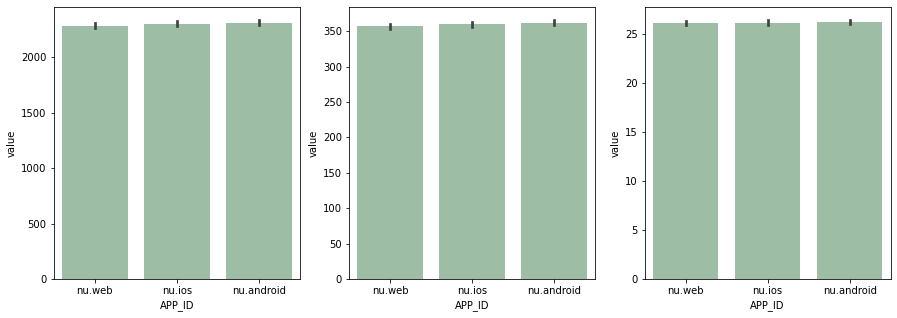

In [46]:
# generate a boxplot to see the data distribution by treatments. Using boxplot, we can 
# easily detect the differences between different treatments
fig, axes= plt.subplots(1, 3, figsize=(15, 5))
with_outliers = True
ax0 = sns.barplot(x='APP_ID', y='value', data=df_melt.loc[df_melt["variable"] == "num_chars"], color='#99c2a2', ax=axes[0])
ax1 = sns.barplot(x='APP_ID', y='value', data=df_melt.loc[df_melt["variable"] == "num_words"], color='#99c2a2', ax=axes[1])
ax2 = sns.barplot(x='APP_ID', y='value', data=df_melt.loc[df_melt["variable"] == "num_sentences"], color='#99c2a2', ax=axes[2])
# for ax in [ax0,ax1,ax2]:
#     ax.set_xlim()

plt.show()



In [48]:
ddf3 = ddf2[["article_id"]].merge(ddf_views[["ARTICLE_ID", "APP_ID", "hour"]], left_on='article_id', right_on='ARTICLE_ID')
ddf3.head()

,article_id,ARTICLE_ID,APP_ID,hour
0,6178557,6178557,nu.web,18
1,6180191,6180191,nu.web,18
2,6180191,6180191,nu.web,14
3,6180471,6180471,nu.web,20
4,5610674,5610674,nu.web,20


# Correlation device and time of day
A graph has been created showing at what time of day interactions took place per device type. The samples taken from each category are equal, since in the dataset nu.web occurs more frequently than nu.ios and nu.android.

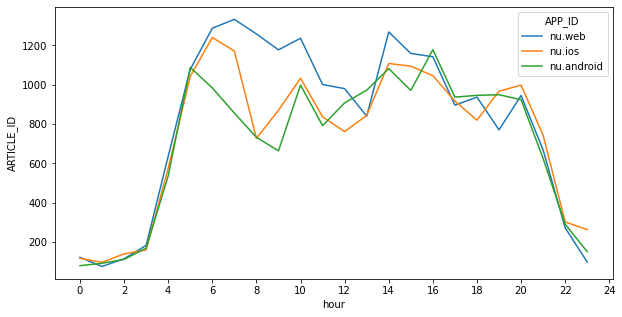

In [40]:
# TODO: Add a normalized graph
stepsize = 2
fig = plt.figure(figsize=(10, 5))
ax = sns.lineplot(x="hour", y="ARTICLE_ID", hue="APP_ID" ,data=ddf3.groupby(["APP_ID", "hour"]).count().reset_index().compute())
ax.xaxis.set_ticks(np.arange(0, 26, stepsize))
plt.show()

In [41]:
from scipy.stats import entropy

ddf_topics = dd.read_csv(f'data_dpg_testdata/{DATA_FOLDER_ARTICLES}/reduced_articles_df_fixed_set_topics.csv', dtype={'sub_section': 'object',
       'url': 'object'},)
topic_columns = ddf_topics.columns[ddf_topics.columns.str.startswith("topic_")].values

ddf_topics = ddf_topics.reset_index().set_index('index')
ddf_topics = ddf_topics.assign(article_topic_entropy = dd.from_array(entropy(ddf_topics[topic_columns], axis=1)))
ddf_topics = ddf_topics.assign(argmax_topic = dd.from_array(ddf_topics[topic_columns].idxmax(axis=1).compute().values))
ddf_topics.head()

,article_id,topic_voetbal,topic_optredens_en_voorstellingen,topic_politiek,topic_technologie_en_handel,topic_relatie_en_opvoeden,topic_bestuur_en_organisatie,topic_human_interest,topic_verkeersongevallen,topic_nominatie_en_prijzen,...,topic_overheidsbeleid,topic_vakbond_club_en_vereniging,topic_religie,topic_bouwen_en_wonen,topic_recht_en_justitie,topic_samenleving,topic_woon_en_leefomgeving,file_name,article_topic_entropy,argmax_topic
index,,,,,,,,,,,,,,,,,,,,,
0,6178608,0.043142,0.001140,0.000977,0.085372,0.002397,0.001183,0.001791,0.000650,0.000829,...,0.130365,0.030968,0.000838,0.000758,0.000944,0.000691,0.019378,0,1.888799,topic_economie
1,6178610,0.000512,0.000453,0.025080,0.000563,0.048403,0.022881,0.205593,0.124505,0.000328,...,0.000514,0.007522,0.000332,0.000300,0.087054,0.000274,0.035372,0,2.598057,topic_human_interest
2,6178739,0.003579,0.003158,0.002706,0.003929,0.159745,0.003275,0.185203,0.001801,0.002296,...,0.003594,0.029818,0.002322,0.002099,0.002614,0.095430,0.006187,0,2.133297,topic_natuur
3,6178681,0.439941,0.049329,0.001649,0.002393,0.004043,0.001995,0.003003,0.001097,0.087265,...,0.037873,0.042356,0.030830,0.001279,0.001592,0.001167,0.003778,0,2.087796,topic_voetbal
4,6178734,0.018255,0.016113,0.013809,0.020110,0.033269,0.016706,0.025336,0.009188,0.185835,...,0.018353,0.009997,0.011844,0.010708,0.013332,0.009771,0.264851,0,2.875331,topic_woon_en_leefomgeving


In [42]:
ddf_topics_merged = ddf_topics.merge(ddf_views[["ARTICLE_ID", "APP_ID"]], how="inner", left_on='article_id', right_on='ARTICLE_ID')
# ddf_topics_merged = ddf_topics_merged.reset_index().set_index('index')
# ddf_topics_merged = ddf_topics_merged.assign(argmax_topic = pd.from_array(ddf_topics_merged[topic_columns].idxmax(axis=1).compute().values))
# ddf_topics_merged = ddf_topics_merged.reset_index(drop=True).reset_index()
display(ddf_topics_merged.head())


,article_id,topic_voetbal,topic_optredens_en_voorstellingen,topic_politiek,topic_technologie_en_handel,topic_relatie_en_opvoeden,topic_bestuur_en_organisatie,topic_human_interest,topic_verkeersongevallen,topic_nominatie_en_prijzen,...,topic_religie,topic_bouwen_en_wonen,topic_recht_en_justitie,topic_samenleving,topic_woon_en_leefomgeving,file_name,article_topic_entropy,argmax_topic,ARTICLE_ID,APP_ID
0,6180191,0.026076,0.000597,0.000510,0.021621,0.043234,0.000618,0.066839,0.000340,0.000433,...,0.006985,0.000396,0.000493,0.000361,0.024758,0,2.249905,topic_gezondheid_en_zorg,6180191,nu.web
1,6180505,0.001771,0.001563,0.001339,0.001942,0.003432,0.001622,0.002457,0.000891,0.001136,...,0.001149,0.152208,0.001293,0.000948,0.102990,0,1.609093,topic_economie,6180505,nu.web
2,6180696,0.002656,0.002344,0.002008,0.105801,0.036922,0.084021,0.003651,0.001337,0.001704,...,0.001723,0.001558,0.001940,0.025332,0.004558,0,2.262331,topic_veiligheid,6180696,nu.web
3,6175411,0.004710,0.112150,0.003562,0.005172,0.008761,0.086660,0.327084,0.002371,0.003022,...,0.003056,0.002763,0.003440,0.002521,0.008156,0,2.288641,topic_human_interest,6175411,nu.web
4,6177917,0.002504,0.067823,0.001894,0.002748,0.463120,0.045923,0.031484,0.001260,0.033933,...,0.001625,0.001469,0.001829,0.001340,0.049518,0,1.883704,topic_relatie_en_opvoeden,6177917,nu.web


# Correlation device and topic
For a correlation between device type and topic, only the most prominent topic from the articles has been considered. Kruskal Wallis H reveals a signficant relation between the topics and device type.

3it [00:00,  7.02it/s]


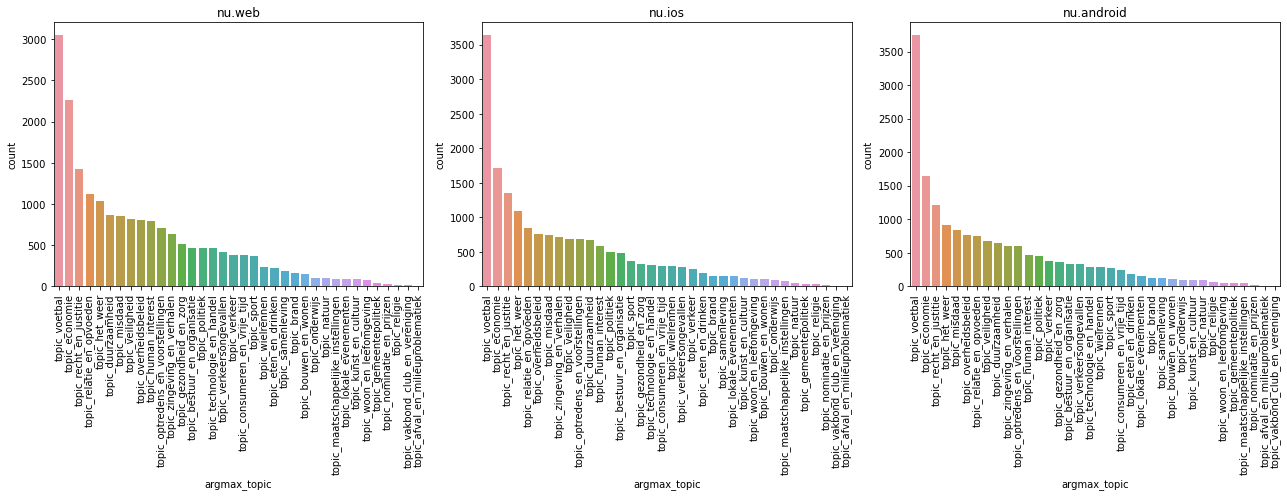

In [43]:
fig, axes = plt.subplots(1,3, figsize=(18, 7))
faxes = axes.flatten()
tmp = ddf_topics_merged[["argmax_topic", "APP_ID"]].compute()
for device, ax in tqdm.tqdm(zip(unique_devices, faxes)):
    order = tmp.loc[tmp["APP_ID"]==device]["argmax_topic"].value_counts().index
    ax = sns.countplot(data=tmp.loc[tmp["APP_ID"]==device], x="argmax_topic", ax=ax, order=order)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, ha="center")
    ax.set_title(device)
fig.tight_layout()
plt.show()

In [44]:

l_test_results = list()
tmp = ddf_topics_merged.sample(frac=1).compute()
for topic in tqdm.tqdm(topic_columns):
    res = {"topic": topic, **pg.kruskal(data=tmp, dv=topic, between="APP_ID").iloc[0].to_dict()}
    l_test_results.append(res)
df_test_results = pd.DataFrame(l_test_results).sort_values("p-unc")
df_test_results

100%|██████████| 36/36 [00:01<00:00, 27.88it/s]


,topic,Source,ddof1,H,p-unc
0,topic_voetbal,APP_ID,2,238.380132,1.723503e-52
17,topic_gezondheid_en_zorg,APP_ID,2,180.518994,6.321185e-40
12,topic_economie,APP_ID,2,179.841950,8.867817e-40
28,topic_consumeren_en_vrije_tijd,APP_ID,2,166.747578,6.183346e-37
19,topic_sport,APP_ID,2,153.086556,5.723698e-34
23,topic_duurzaamheid,APP_ID,2,120.631372,6.386023e-27
32,topic_bouwen_en_wonen,APP_ID,2,118.058505,2.311646e-26
18,topic_gemeentepolitiek,APP_ID,2,117.753966,2.691852e-26
34,topic_samenleving,APP_ID,2,105.475690,1.248087e-23
2,topic_politiek,APP_ID,2,99.738386,2.198288e-22


100%|██████████| 36/36 [00:13<00:00,  2.75it/s]


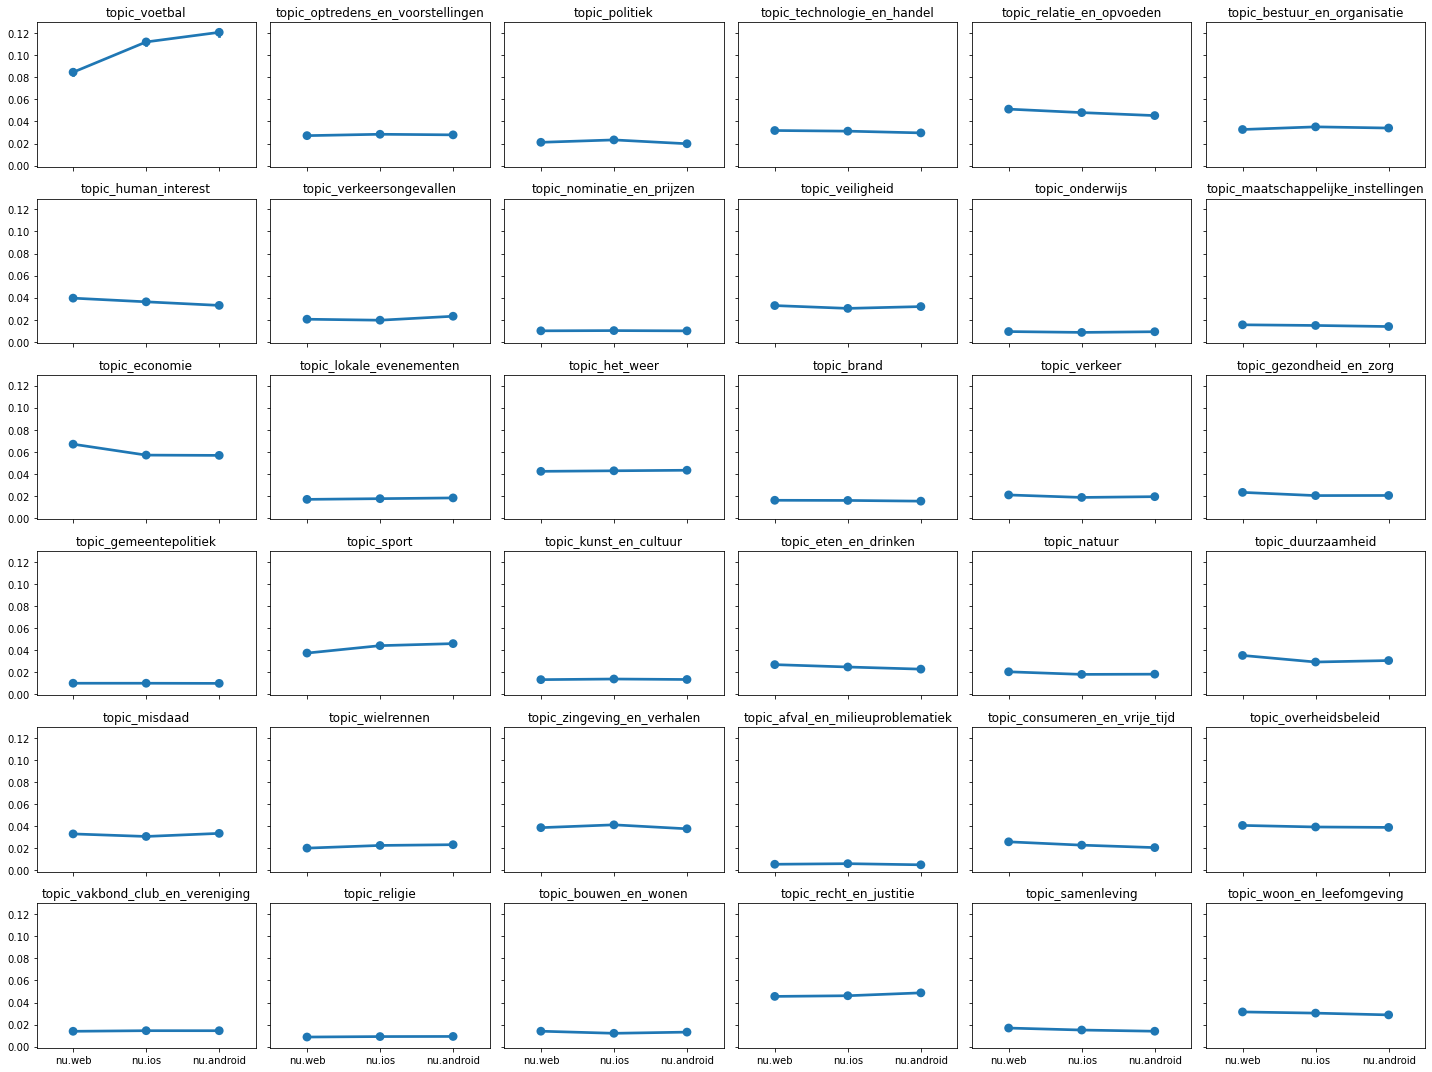

In [45]:
# TODO: Correct the yscales
fig, axes = plt.subplots(6,6,figsize=(20, 15), sharey=False, sharex=True)
faxes = axes.flatten()
tmp = ddf_topics_merged.sample(frac=1).compute()
for topic, ax in tqdm.tqdm(zip(topic_columns, faxes), total=len(topic_columns)):
    ax = sns.pointplot(data=tmp, x="APP_ID", y=topic, ax=ax)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_title(topic)
fig.tight_layout()  
plt.show()

# Correlation device and topic diversity
Topic diversity has been measured in terms of article entropy. The means of the entropies of articles across device types has been compared. Since it looks like a normal distribution, ANOVA has been applied. It results in a signficant p-value, but a low np2 means a small effect size.
There are no discernible clusters in a 2-dimensional space.


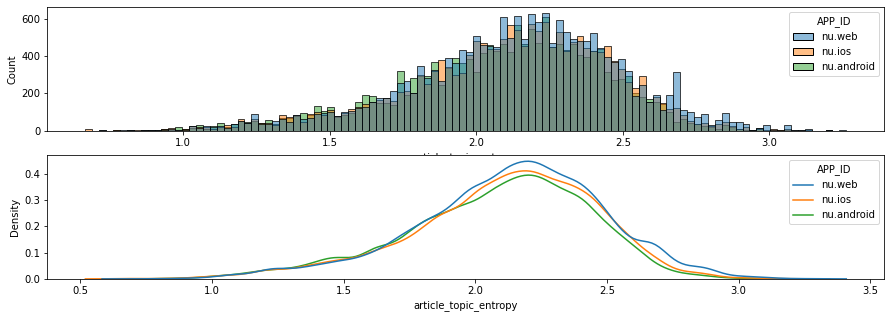

In [46]:
fig, axes = plt.subplots(2,1,figsize=(15, 5))
tmp = ddf_topics_merged.sample(frac=1).compute().reset_index()
sns.histplot(data=tmp, x="article_topic_entropy", hue="APP_ID", ax=axes[0])
sns.kdeplot(data=tmp, x="article_topic_entropy", hue="APP_ID", ax=axes[1])
plt.show()

In [47]:
# median_fun = pd.Aggregation(
#     name="median",
#     # this computes the median on each partition
#     chunk=lambda s: s.median(),
#     # this combines results across partitions; the input should just be a list of length 1
#     agg=lambda s0: s0.sum(),
# )
ddf_topics_merged[["APP_ID", "article_topic_entropy"]].groupby("APP_ID").agg(["mean", "std", "min", "max"]).compute()

article_topic_entropy                              
                            mean       std       min       max
APP_ID                                                        
nu.web                  2.138416  0.356699  0.638017  3.261815
nu.ios                  2.110818  0.354154  0.667255  3.261800
nu.android              2.083988  0.350935  0.730100  3.197385

In [48]:
tmp = ddf_topics_merged.compute()
pg.anova(data=tmp, dv='article_topic_entropy', between='APP_ID')

,Source,ddof1,ddof2,F,p-unc,np2
0,APP_ID,2,54305,109.151706,4.909560e-48,0.004004


<AxesSubplot:xlabel='APP_ID', ylabel='article_topic_entropy'>

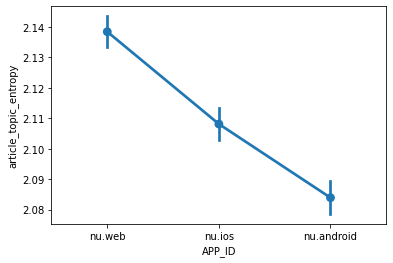

In [49]:
fig, ax = plt.subplots(1,1)
sns.pointplot(data=tmp, x="APP_ID", y='article_topic_entropy', ax=ax)

In [50]:
centroids = ddf_topics_merged[["APP_ID"]+list(topic_columns)].groupby("APP_ID").agg(np.mean).compute()
centroids

,topic_voetbal,topic_optredens_en_voorstellingen,topic_politiek,topic_technologie_en_handel,topic_relatie_en_opvoeden,topic_bestuur_en_organisatie,topic_human_interest,topic_verkeersongevallen,topic_nominatie_en_prijzen,topic_veiligheid,...,topic_zingeving_en_verhalen,topic_afval_en_milieuproblematiek,topic_consumeren_en_vrije_tijd,topic_overheidsbeleid,topic_vakbond_club_en_vereniging,topic_religie,topic_bouwen_en_wonen,topic_recht_en_justitie,topic_samenleving,topic_woon_en_leefomgeving
APP_ID,,,,,,,,,,,,,,,,,,,,,
nu.web,0.087646,0.027928,0.021131,0.031340,0.050740,0.032521,0.039209,0.020243,0.009788,0.033295,...,0.038934,0.005434,0.025206,0.040464,0.013800,0.008843,0.015075,0.045530,0.017120,0.031581
nu.ios,0.111703,0.028423,0.021161,0.029728,0.048126,0.034965,0.035702,0.019194,0.010384,0.030581,...,0.041946,0.006204,0.023663,0.038780,0.014414,0.009135,0.012657,0.047609,0.014768,0.029942
nu.android,0.120079,0.027760,0.020187,0.030190,0.044623,0.033948,0.032947,0.023533,0.009878,0.032361,...,0.038999,0.005191,0.021224,0.038394,0.014490,0.009134,0.013262,0.047682,0.013877,0.028230


In [51]:
# https://github.com/silviatti/topic-model-diversity
X = centroids.values
pd.DataFrame(cdist(X,X, "euclidean"), index=centroids.index, columns=centroids.index)

APP_ID,nu.web,nu.ios,nu.android
APP_ID,,,
nu.web,0.000000,0.029063,0.038400
nu.ios,0.029063,0.000000,0.012529
nu.android,0.038400,0.012529,0.000000


In [52]:
# https://github.com/silviatti/topic-model-diversity
X = centroids.values
pd.DataFrame(cdist(X,X, "cosine"), index=centroids.index, columns=centroids.index)

APP_ID,nu.web,nu.ios,nu.android
APP_ID,,,
nu.web,2.220446e-16,0.010007,0.016949
nu.ios,1.000670e-02,0.000000,0.001755
nu.android,1.694938e-02,0.001755,0.000000


<AxesSubplot:>

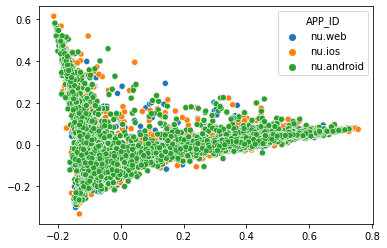

In [53]:
from sklearn.decomposition import PCA
reducer = PCA(2)
data = ddf_topics_merged.sample(frac=1).dropna().compute()
reduced_data = reducer.fit_transform(data[list(topic_columns)])
sns.scatterplot(x = reduced_data[:, 0], y = reduced_data[:, 1], hue=data["APP_ID"])

# Correlation device and USERNEEDS
Kruskal Wallis H reveals a signficant p-value for all the different userneeds across device types

In [54]:
ddf_userneeds = dd.read_csv(f'data_dpg_testdata/{DATA_FOLDER_ARTICLES}/reduced_articles_df_fixed_set_userneeds.csv', dtype={'sub_section': 'object',
       'url': 'object'},)
columns_userneeds = ddf_userneeds.columns[ddf_userneeds.columns.str.startswith("userneed_")].values
ddf_userneeds = ddf_userneeds.assign(argmax_userneeds = ddf_userneeds[columns_userneeds].idxmax(axis=1))
ddf_userneeds.head()

,article_id,userneed_hou_me_op_de_hoogte,userneed_geef_me_context,userneed_vermaak_me,userneed_raak_me_verbind_me,userneed_help_me,file_name,argmax_userneeds
0,6178608,0.987202,0.007797,0.001776,0.002230,0.000995,0,userneed_hou_me_op_de_hoogte
1,6178610,0.018365,0.010142,0.098376,0.234295,0.638822,0,userneed_help_me
2,6178739,0.891345,0.025051,0.049026,0.029105,0.005473,0,userneed_hou_me_op_de_hoogte
3,6178681,0.481953,0.379622,0.118641,0.010875,0.008909,0,userneed_hou_me_op_de_hoogte
4,6178734,0.033568,0.048142,0.808459,0.091164,0.018666,0,userneed_vermaak_me


In [55]:
ddf_userneeds_merged = ddf_userneeds.merge(ddf_views[["ARTICLE_ID", "APP_ID"]], how="inner", left_on='article_id', right_on='ARTICLE_ID')
ddf_userneeds_merged.head()

,article_id,userneed_hou_me_op_de_hoogte,userneed_geef_me_context,userneed_vermaak_me,userneed_raak_me_verbind_me,userneed_help_me,file_name,argmax_userneeds,ARTICLE_ID,APP_ID
0,6175411,0.224188,0.030122,0.424995,0.313139,0.007556,0,userneed_vermaak_me,6175411,nu.web
1,6179046,0.088191,0.778915,0.092867,0.035675,0.004352,0,userneed_geef_me_context,6179046,nu.web
2,6177597,0.019615,0.197310,0.203897,0.372778,0.206400,0,userneed_raak_me_verbind_me,6177597,nu.web
3,6180111,0.029606,0.385046,0.325540,0.139539,0.120269,0,userneed_geef_me_context,6180111,nu.web
4,6176695,0.122034,0.774919,0.078232,0.007682,0.017134,0,userneed_geef_me_context,6176695,nu.web


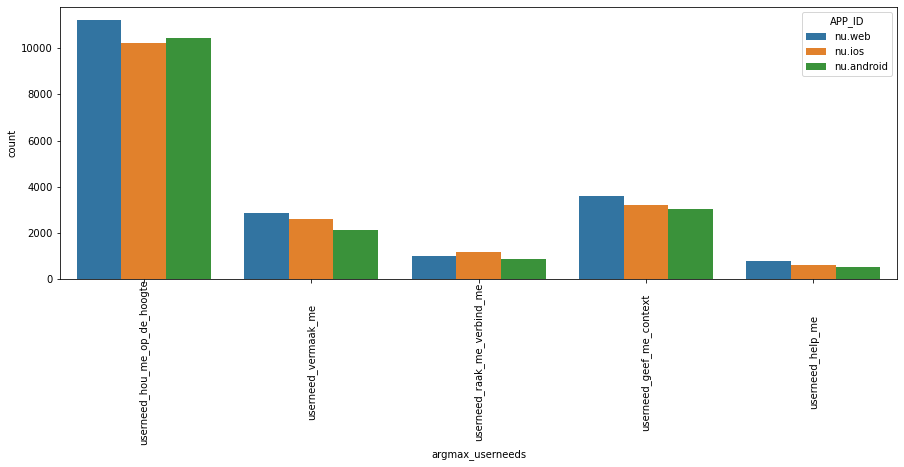

In [56]:
fig, axes = plt.subplots(1,1,figsize=(15, 5))
tmp = ddf_userneeds_merged[["argmax_userneeds", "APP_ID"]].compute()
ax = sns.countplot(data=tmp, x="argmax_userneeds", hue="APP_ID", ax=axes)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, va="center", position=(0,-0.28))
plt.show()

In [57]:
l_test_results = list()
tmp = ddf_userneeds_merged.sample(frac=1).compute()
for need in tqdm.tqdm(columns_userneeds):
    res = {"need": need, **pg.kruskal(data=tmp, dv=need, between="APP_ID").iloc[0].to_dict()}
    l_test_results.append(res)
df_test_results = pd.DataFrame(l_test_results).sort_values("p-unc")
df_test_results

100%|██████████| 5/5 [00:00<00:00, 27.41it/s]


,need,Source,ddof1,H,p-unc
4,userneed_help_me,APP_ID,2,108.655885,2.544922e-24
0,userneed_hou_me_op_de_hoogte,APP_ID,2,108.504650,2.744825e-24
2,userneed_vermaak_me,APP_ID,2,83.508036,7.352928e-19
3,userneed_raak_me_verbind_me,APP_ID,2,73.142750,1.309947e-16
1,userneed_geef_me_context,APP_ID,2,13.560189,1.136168e-03


100%|██████████| 5/5 [00:01<00:00,  2.82it/s]


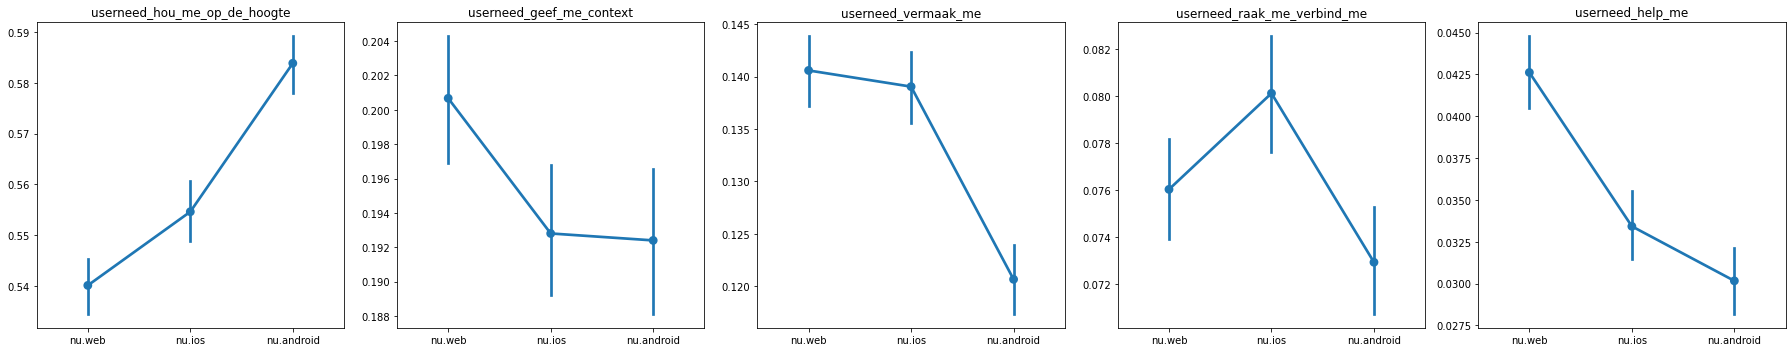

In [58]:
fig, axes = plt.subplots(1, len(columns_userneeds),figsize=(25, 5), sharey=False, sharex=True)
faxes = axes.flatten()
tmp = ddf_userneeds_merged.sample(frac=1).compute()
for need, ax in tqdm.tqdm(zip(columns_userneeds, faxes), total=len(columns_userneeds)):
    ax = sns.pointplot(data=tmp, x="APP_ID", y=need, ax=ax)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_title(need)
fig.tight_layout()  
plt.show()

# LOCATION

In [59]:
# https://pypi.org/project/pgeocode/
# https://www.cbs.nl/en-gb/our-services/open-data/statline-as-open-data/cartography
ddf_location = ddf_views 
ddf_location.head()


,APP_ID,ARTICLE_ID,DERIVED_TSTAMP,GEO_CITY,GEO_COUNTRY,GEO_ZIPCODE,REFR_MEDIUM,REFR_URLHOST,QUASI_USER_ID,IS_LOGGED_IN,...,privacy_analytics,privacy_target_advertising,privacy_personalisation,privacy_non-personalised_ads,privacy_marketing,privacy_social_media,privacy_geo_location,privacy_advertising,file_name,hour
0,nu.web,6215598,2022-08-02 14:22:40.974000+00:00,7,NL,1093,internal,1,748b29d30aad787d773fb1634e845ab7,1,...,1,0,1,1,1,1,0,1,123,14
1,nu.web,6220215,2022-08-27 13:56:01.029000+00:00,7,NL,1012,internal,1,365bd2c6bc41ea25e5b95a00480deae1,1,...,1,0,1,1,1,1,0,1,148,13
2,nu.web,6221396,2022-09-02 05:31:47.731000+00:00,96,NL,5707,internal,1,a1db8ddf72026d374e73c0285ece395a,1,...,1,0,1,1,1,1,0,1,154,5
3,nu.web,6206928,2022-06-16 16:39:24.405000+00:00,230,NL,6213,internal,1,5ade54452a16658be5f82453ec322661,1,...,1,0,1,1,1,1,0,1,76,16
4,nu.web,6212078,2022-07-14 03:47:50.565000+00:00,57,NL,4707,internal,1,8e7c66f27c536f689e3ed7bc0aca8351,1,...,1,0,1,1,1,1,0,1,104,3


# INTERACTION

In [60]:
DATA_FOLDER = "reduced"
ddf_interactions = dd.read_csv(f'data_dpg_testdata/{DATA_FOLDER}/reduced_interactions.csv', dtype={'sub_section': 'object',
       'url': 'object'},)
tmp = ddf_interactions[["ARTICLE_ID","SE_LABEL", "SE_ACTION"]].compute()
unique_interactions_1 = tmp["SE_LABEL"].unique()
unique_interactions_2 = tmp["SE_ACTION"].unique()
ddf_interactions.head()

,APP_ID,ARTICLE_ID,DERIVED_TSTAMP,SE_ACTION,SE_CATEGORY,SE_LABEL,SE_VALUE,QUASI_USER_ID,IS_LOGGED_IN,GEO_CITY,...,privacy_personalisation,privacy_non-personalised_ads,privacy_marketing,privacy_social_media,privacy_geo_location,privacy_advertising,file_name,GEO_COUNTRY,GEO_ZIPCODE,REFR_MEDIUM
0,nu.web,6192670,2022-04-01T07:16:48.806Z,post-reaction,nujij,comment-on-reaction,1.0,780840469334879923dbe38c0e8a2ab3,1,24,...,1,1,1,1,0,1,0,NaN,NaN,NaN
1,nu.web,6192592,2022-04-01T08:02:14.027Z,post-reaction,nujij,new-reaction,1.0,5132ce5b0ccb5b3a2f9b2775a99d2ee7,1,15,...,1,1,1,1,0,1,0,NL,3079,NaN
2,nu.web,6192670,2022-04-01T08:01:27.569Z,post-reaction,nujij,comment-on-reaction,1.0,e9dcaa5ab5e431e1f86a018e92008043,1,303,...,1,1,1,1,0,1,0,NL,3893,internal
3,nu.web,6192670,2022-04-01T08:02:12.540Z,post-reaction,nujij,new-reaction,1.0,9fdbeac954e9c98ab8323f6fc2520910,1,16,...,1,1,1,1,0,1,0,NL,2513,NaN
4,nu.web,6192629,2022-04-01T07:51:56.635Z,post-reaction,nujij,comment-on-reaction,1.0,fc39be4398815482fe41575af63f6587,1,615,...,1,1,1,1,0,1,0,BE,2280,NaN


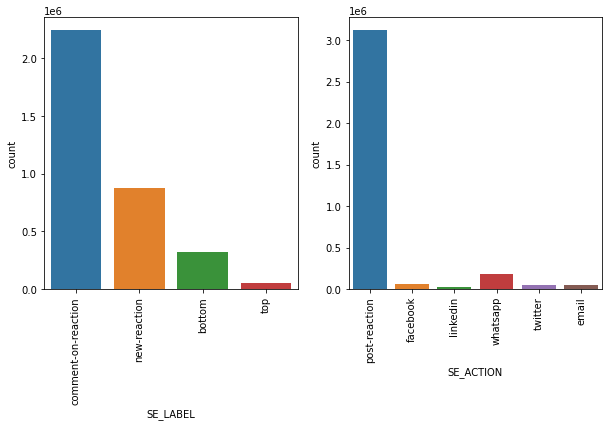

In [61]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.countplot(data=tmp, x="SE_LABEL", ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation = 90)
sns.countplot(data=tmp, x="SE_ACTION", ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation = 90)
plt.show()


In [62]:
ddf_topics_merged_interactions = ddf_topics.merge(ddf_interactions[["ARTICLE_ID", "SE_LABEL", "SE_ACTION"]], how="inner", left_on='article_id', right_on='ARTICLE_ID')
display(ddf_topics_merged.head())


,article_id,topic_voetbal,topic_optredens_en_voorstellingen,topic_politiek,topic_technologie_en_handel,topic_relatie_en_opvoeden,topic_bestuur_en_organisatie,topic_human_interest,topic_verkeersongevallen,topic_nominatie_en_prijzen,...,topic_religie,topic_bouwen_en_wonen,topic_recht_en_justitie,topic_samenleving,topic_woon_en_leefomgeving,file_name,article_topic_entropy,argmax_topic,ARTICLE_ID,APP_ID
0,6177755,0.000718,0.016510,0.015279,0.124217,0.036993,0.000657,0.059940,0.000362,0.000461,...,0.000466,0.000421,0.000525,0.000385,0.070041,0,2.296793,topic_duurzaamheid,6177755,nu.web
1,6179018,0.001628,0.001437,0.042458,0.001793,0.012395,0.001491,0.002236,0.000819,0.001044,...,0.001056,0.000955,0.001189,0.000871,0.002805,0,1.673688,topic_overheidsbeleid,6179018,nu.web
2,6179548,0.000633,0.000559,0.000479,0.000696,0.395557,0.012948,0.087378,0.000318,0.000406,...,0.074052,0.000371,0.129835,0.000339,0.027879,0,1.982372,topic_relatie_en_opvoeden,6179548,nu.web
3,6180111,0.000690,0.000609,0.015338,0.024519,0.001279,0.000632,0.000954,0.018263,0.000443,...,0.000448,0.054415,0.000504,0.000369,0.166669,0,2.301705,topic_economie,6180111,nu.web
4,6180111,0.000690,0.000609,0.015338,0.024519,0.001279,0.000632,0.000954,0.018263,0.000443,...,0.000448,0.054415,0.000504,0.000369,0.166669,0,2.301705,topic_economie,6180111,nu.web


4it [00:03,  1.31it/s]


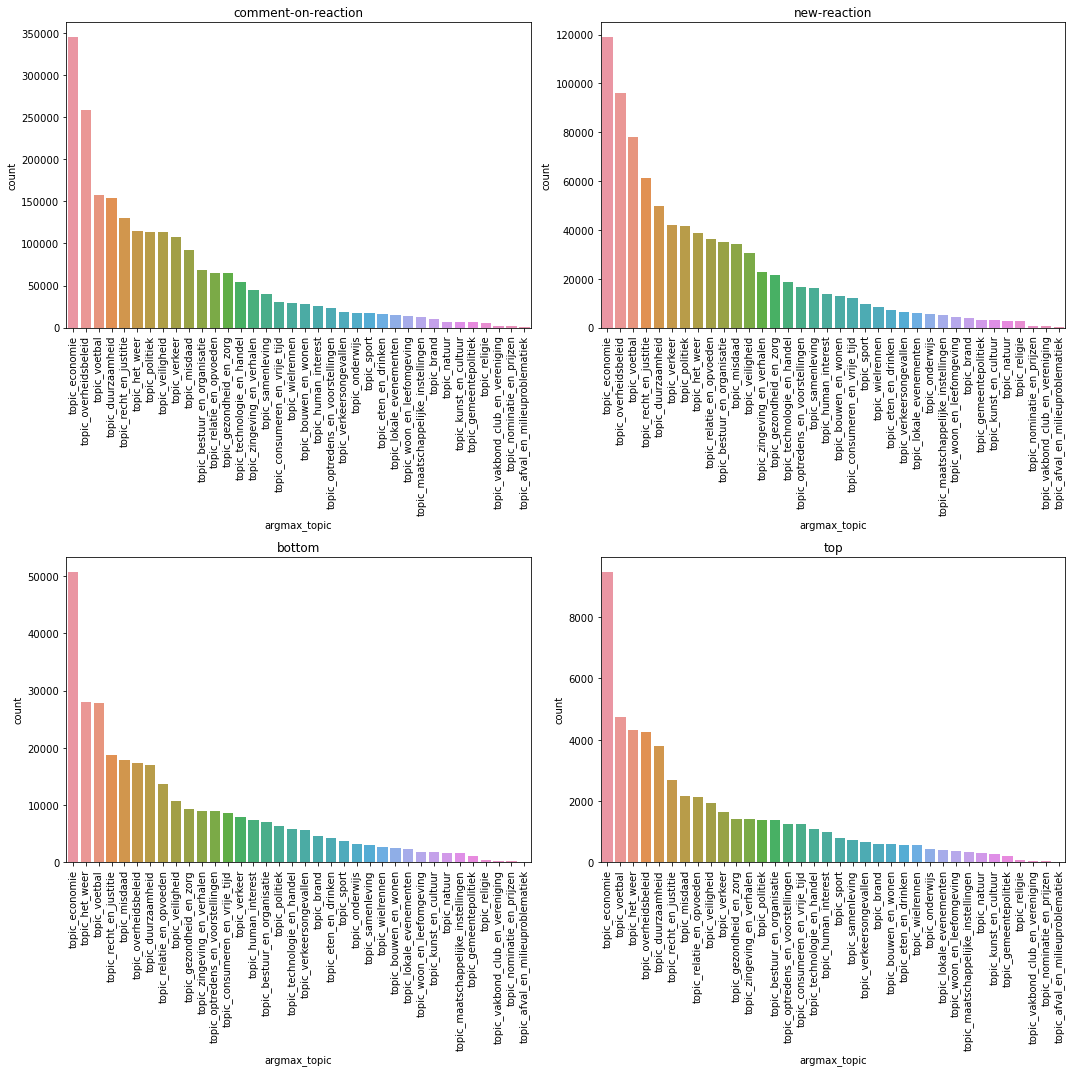

In [63]:
fig, axes = plt.subplots(2,(len(unique_interactions_1)//2), figsize=(15, 15))
faxes = axes.flatten()
tmp = ddf_topics_merged_interactions[["argmax_topic", "SE_LABEL"]].compute()
for interaction, ax in tqdm.tqdm(zip(unique_interactions_1, faxes)):
    order = tmp.loc[tmp["SE_LABEL"]==interaction]["argmax_topic"].value_counts().index
    ax = sns.countplot(data=tmp.loc[tmp["SE_LABEL"]==interaction], x="argmax_topic", ax=ax, order=order)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, ha="center")
    ax.set_title(interaction)
fig.tight_layout()
plt.show()

6it [00:03,  1.58it/s]


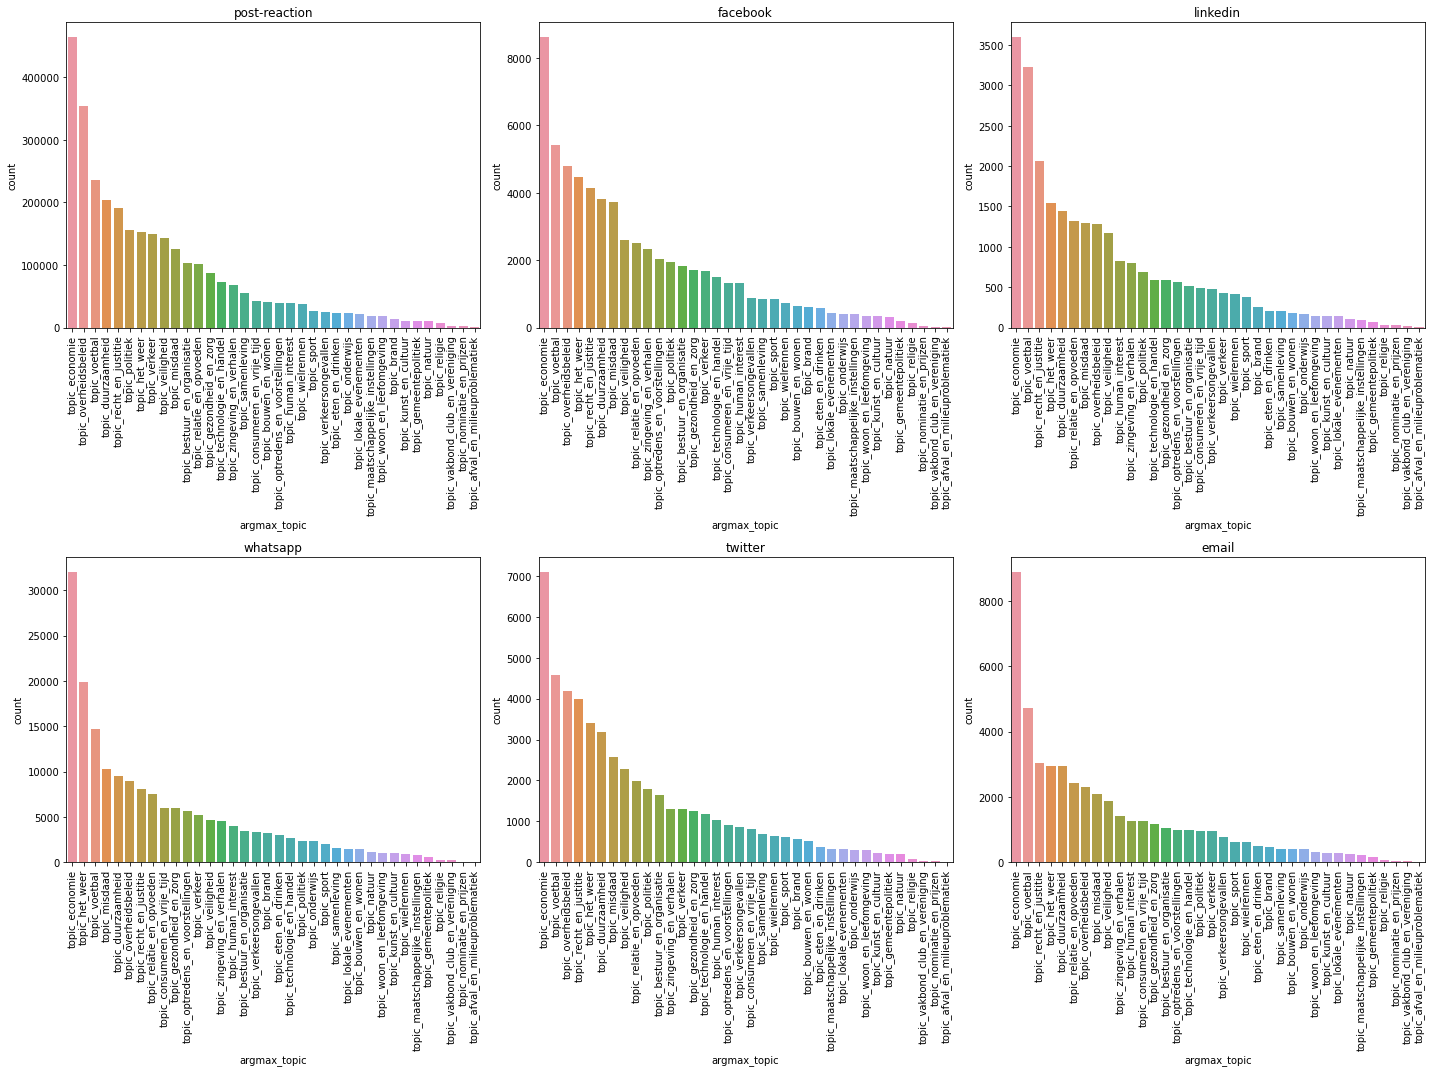

In [64]:
fig, axes = plt.subplots(2,(len(unique_interactions_2)//2), figsize=(20, 15))
faxes = axes.flatten()
tmp = ddf_topics_merged_interactions[["argmax_topic", "SE_ACTION"]].compute()
for interaction, ax in tqdm.tqdm(zip(unique_interactions_2, faxes)):
    order = tmp.loc[tmp["SE_ACTION"]==interaction]["argmax_topic"].value_counts().index
    ax = sns.countplot(data=tmp.loc[tmp["SE_ACTION"]==interaction], x="argmax_topic", ax=ax, order=order)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, ha="center")
    ax.set_title(interaction)
fig.tight_layout()
plt.show()

In [65]:
l_test_results = list()
tmp = ddf_topics_merged_interactions.sample(frac=1).compute()
for topic in tqdm.tqdm(topic_columns):
    res = {"topic": topic, **pg.kruskal(data=tmp, dv=topic, between="SE_LABEL").iloc[0].to_dict()}
    l_test_results.append(res)
df_test_results = pd.DataFrame(l_test_results).sort_values("p-unc")
df_test_results

100%|██████████| 36/36 [01:01<00:00,  1.71s/it]


,topic,Source,ddof1,H,p-unc
0,topic_voetbal,SE_LABEL,3,9753.823370,0.000000e+00
33,topic_recht_en_justitie,SE_LABEL,3,1630.669308,0.000000e+00
32,topic_bouwen_en_wonen,SE_LABEL,3,2555.739204,0.000000e+00
31,topic_religie,SE_LABEL,3,2245.744088,0.000000e+00
30,topic_vakbond_club_en_vereniging,SE_LABEL,3,1893.027388,0.000000e+00
29,topic_overheidsbeleid,SE_LABEL,3,28409.047420,0.000000e+00
28,topic_consumeren_en_vrije_tijd,SE_LABEL,3,10353.278190,0.000000e+00
27,topic_afval_en_milieuproblematiek,SE_LABEL,3,3984.242821,0.000000e+00
26,topic_zingeving_en_verhalen,SE_LABEL,3,6381.344696,0.000000e+00
25,topic_wielrennen,SE_LABEL,3,2980.173311,0.000000e+00


100%|██████████| 36/36 [00:09<00:00,  3.88it/s]


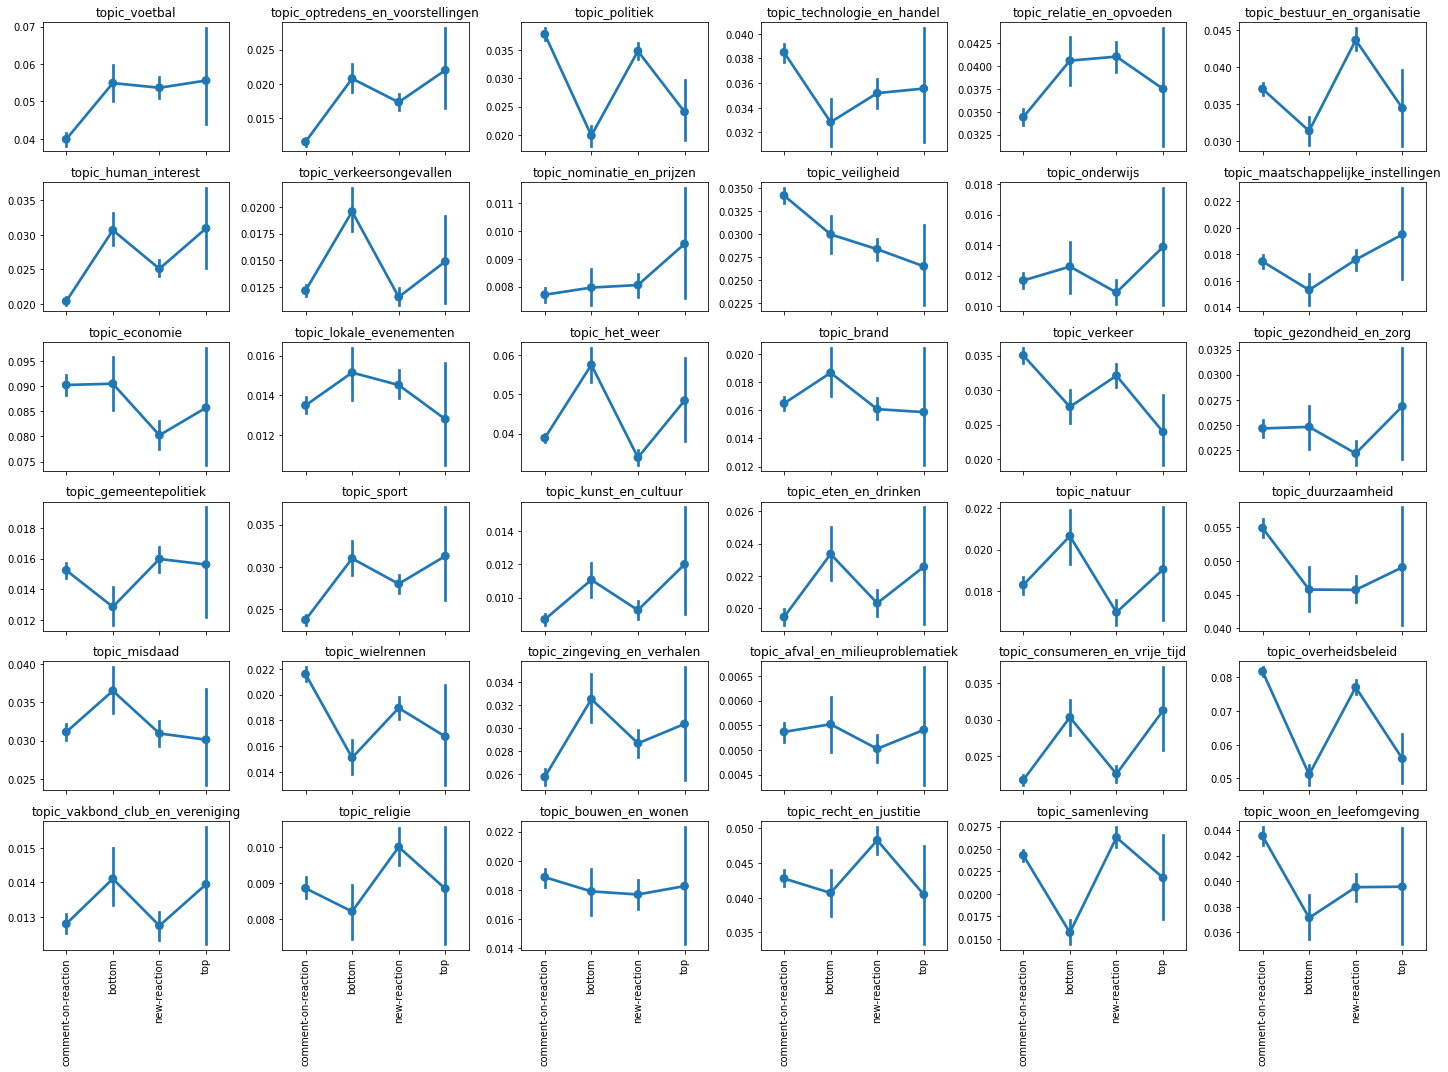

In [66]:
# TODO: Change the scale so it's not shared between the plots
fig, axes = plt.subplots(6,6,figsize=(20, 15), sharey=False, sharex=True)
faxes = axes.flatten()
tmp = ddf_topics_merged_interactions.sample(frac=0.01).compute()
for topic, ax in tqdm.tqdm(zip(topic_columns, faxes), total=len(topic_columns)):
    ax = sns.pointplot(data=tmp, x="SE_LABEL", y=topic, ax=ax)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, ha="center")
    ax.set_title(topic)
fig.tight_layout()  
plt.show()

100%|██████████| 36/36 [01:11<00:00,  1.98s/it]


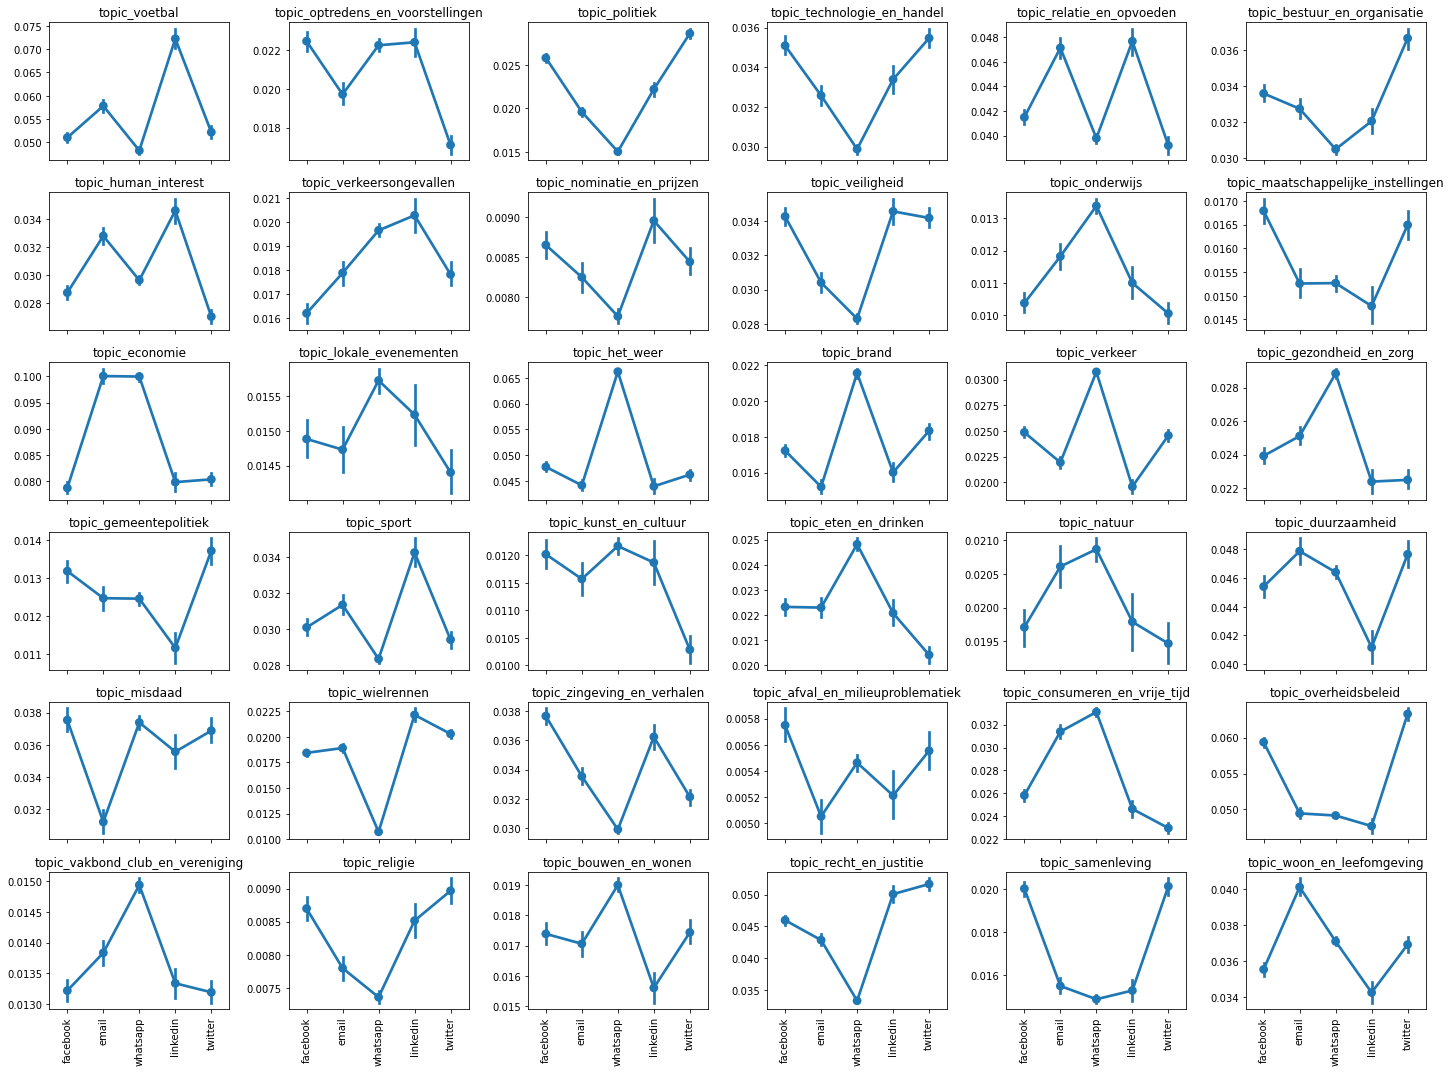

In [69]:
fig, axes = plt.subplots(6,6,figsize=(20, 15), sharey=False, sharex=True)
faxes = axes.flatten()
tmp = ddf_topics_merged_interactions[ddf_topics_merged_interactions["SE_ACTION"] != "post-reaction"].sample(frac=1).compute()
for topic, ax in tqdm.tqdm(zip(topic_columns, faxes), total=len(topic_columns)):
    ax = sns.pointplot(data=tmp, x="SE_ACTION", y=topic, ax=ax)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, ha="center")
    ax.set_title(topic)
fig.tight_layout()  
plt.show()